## 1. Data Collection and S3 Storage

Our `spy_daily.csv` dataset (daily OHLCV for SPY) has been manually reviewed, cleaned, and uploaded to S3 at:
`s3://aai540-stock-datalake/raw/spy_daily.csv`


## 2. Athena Table Setup

Set up the Athena table to enable SQL-based querying and cataloging of the raw S3 data. (this is run in Athena Console)



-- DDL for Athena table (run in Athena Console)
DROP TABLE IF EXISTS default.spy_daily;

CREATE EXTERNAL TABLE IF NOT EXISTS default.spy_daily (
    date string,
    open double,
    high double,
    low double,
    close double,
    volume bigint
)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.OpenCSVSerde'
WITH SERDEPROPERTIES (
  "separatorChar" = ",",
  "skip.header.line.count" = "1"
)
LOCATION 's3://aai540-stock-datalake/raw/'
TBLPROPERTIES ('has_encrypted_data'='false');


## Exploratory Data Analysis and Feature Engineering

Load the cleaned daily SPY and QQQ datasets, do a quick review, then expand feature engineering to cover the technical signals and anomaly flags outlined in the project plan.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load SPY and QQQ data
df = pd.read_csv('data/spy_daily.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

qqq = pd.read_csv('data/qqq_daily.csv')
qqq['date'] = pd.to_datetime(qqq['date'])
qqq = qqq[['date', 'close']].rename(columns={'close': 'qqq_close'})

# Join for relative strength calculation
df = df.merge(qqq, on='date', how='left')

# Quick look at missing values and summary stats
print(df.isnull().sum())
print(df.describe())


date         0
open         0
high         0
low          0
close        0
volume       0
qqq_close    0
dtype: int64
                                date         open         high          low  \
count                           5033  5033.000000  5033.000000  5033.000000   
mean   2015-04-13 14:36:38.768130304   241.646676   243.015926   240.151912   
min              2005-04-15 00:00:00    67.950000    70.000000    67.100000   
25%              2010-04-15 00:00:00   132.730000   133.400000   131.780000   
50%              2015-04-15 00:00:00   202.400000   203.370000   201.350000   
75%              2020-04-14 00:00:00   314.430000   315.640000   312.760000   
max              2025-04-15 00:00:00   611.540000   613.230000   609.560000   
std                              NaN   132.736560   133.409722   131.984220   

             close        volume    qqq_close  
count  5033.000000  5.033000e+03  5033.000000  
mean    241.677071  1.258952e+08   155.702685  
min      68.110000  1.5270

### Price and Volume Plots

Visualize historical trends for a sanity check.


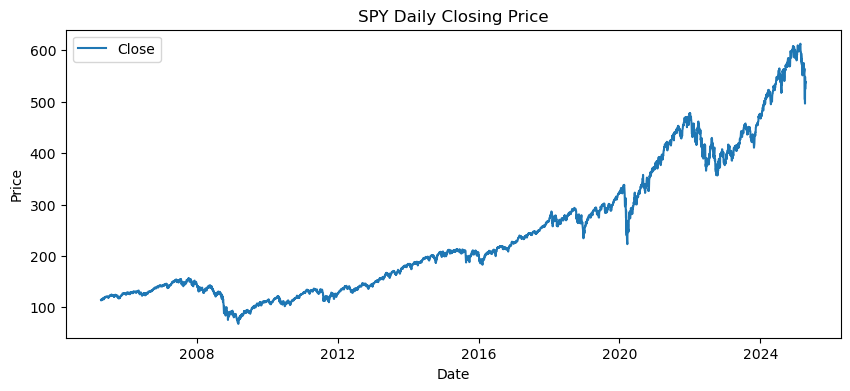

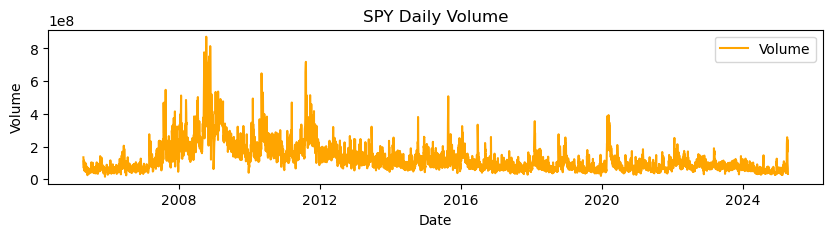

In [2]:
plt.figure(figsize=(10,4))
plt.plot(df['date'], df['close'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPY Daily Closing Price')
plt.legend()
plt.show()

plt.figure(figsize=(10,2))
plt.plot(df['date'], df['volume'], label='Volume', color='orange')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('SPY Daily Volume')
plt.legend()
plt.show()


### Core Feature Engineering

Add returns, moving averages, volatility, RSI, MACD, Bollinger Bands, ATR, VWAP, regime tags, relative strength, and anomaly flags.


In [3]:
# Returns and rolling averages
df['return'] = df['close'].pct_change()
df['sma_5'] = df['close'].rolling(5).mean()
df['sma_10'] = df['close'].rolling(10).mean()
df['sma_20'] = df['close'].rolling(20).mean()
df['sma_50'] = df['close'].rolling(50).mean()
df['volatility_20'] = df['return'].rolling(20).std()

# RSI (14-day)
def calc_rsi(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    ma_up = up.rolling(period).mean()
    ma_down = down.rolling(period).mean()
    rsi = 100 - (100/(1 + ma_up/ma_down))
    return rsi
df['rsi_14'] = calc_rsi(df['close'])

# MACD
df['ema12'] = df['close'].ewm(span=12, adjust=False).mean()
df['ema26'] = df['close'].ewm(span=26, adjust=False).mean()
df['macd'] = df['ema12'] - df['ema26']
df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()

# Bollinger Bands (20d)
df['bb_mid'] = df['close'].rolling(20).mean()
df['bb_std'] = df['close'].rolling(20).std()
df['bb_upper'] = df['bb_mid'] + 2 * df['bb_std']
df['bb_lower'] = df['bb_mid'] - 2 * df['bb_std']

# ATR (14d)
high_low = df['high'] - df['low']
high_close = (df['high'] - df['close'].shift()).abs()
low_close = (df['low'] - df['close'].shift()).abs()
tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
df['atr_14'] = tr.rolling(14).mean()

# VWAP (Volume Weighted Average Price for each day)
df['vwap'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()

# Relative Strength vs QQQ
df['rel_strength_qqq'] = df['close'] / df['qqq_close']

# Regime tagging: simple bull/bear/volatile based on price vs. 50d SMA and rolling vol
conditions = [
    (df['close'] > df['sma_50']) & (df['volatility_20'] < 0.015),
    (df['close'] < df['sma_50']) & (df['volatility_20'] > 0.025),
]
choices = ['bull', 'bear']
df['regime'] = np.select(conditions, choices, default='volatile')

# Volume spike (3x 20d rolling median)
df['vol_spike'] = (df['volume'] > 3 * df['volume'].rolling(20).median()).astype(int)
# Extreme return (|return| > 3x 20d rolling std)
df['extreme_return'] = (df['return'].abs() > 3 * df['return'].rolling(20).std()).astype(int)


### Encode Trend and "In Play" Volume Assumptions

Add columns for trend direction (5SMA/10SMA rule) and a flag for when volume is significantly above normal.


In [4]:
# Trend direction assumption: only trade in the direction of short-term trend
df['trend_up'] = ((df['close'] > df['sma_5']) & (df['close'] > df['sma_10'])).astype(int)
df['trend_down'] = ((df['close'] < df['sma_5']) & (df['close'] < df['sma_10'])).astype(int)

# Volume "in play" flag: today's volume vs. 20-day avg
df['avg_vol_20d'] = df['volume'].rolling(20).mean()
df['in_play_150'] = (df['volume'] >= 1.5 * df['avg_vol_20d']).astype(int)
df['in_play_120'] = (df['volume'] >= 1.2 * df['avg_vol_20d']).astype(int)
df['in_play_200'] = (df['volume'] >= 2.0 * df['avg_vol_20d']).astype(int)


### Clean Up and Save Engineered Features

Drop early rows with NA, check final set, and save to file.


In [5]:
final_features = [
    'date', 'open', 'high', 'low', 'close', 'volume', 'return',
    'sma_5', 'sma_10', 'sma_20', 'sma_50',
    'rsi_14', 'macd', 'macd_signal',
    'bb_mid', 'bb_upper', 'bb_lower',
    'atr_14', 'vwap', 'rel_strength_qqq', 'regime',
    'vol_spike', 'extreme_return',
    'trend_up', 'trend_down', 'in_play_150', 'in_play_120', 'in_play_200'
]

df_feat = df[final_features].dropna().reset_index(drop=True)
df_feat.head()

# Save to disk (for upload to S3/Feature Store if needed)
df_feat.to_csv('data/spy_daily_features.csv', index=False)


### Split Data for Modeling

Train (40%), validation (10%), test (10%), holdout production (40%) split.


In [6]:
n = len(df_feat)
train_end = int(n * 0.4)
val_end = int(n * 0.5)
test_end = int(n * 0.6)

train = df_feat.iloc[:train_end].copy()
val = df_feat.iloc[train_end:val_end].copy()
test = df_feat.iloc[val_end:test_end].copy()
prod = df_feat.iloc[test_end:].copy()

print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")
print(f"Production (holdout) shape: {prod.shape}")


Train shape: (1993, 28)
Validation shape: (499, 28)
Test shape: (498, 28)
Production (holdout) shape: (1994, 28)


### Optionally save splits for future reference or downstream modeling.


In [7]:
train.to_csv('data/spy_daily_train.csv', index=False)
val.to_csv('data/spy_daily_val.csv', index=False)
test.to_csv('data/spy_daily_test.csv', index=False)
prod.to_csv('data/spy_daily_production.csv', index=False)

# Example S3 upload if needed:
# s3.upload_file('data/spy_daily_train.csv', 'aai540-stock-datalake', 'feature_store/spy_daily_train.csv')


## Summary

Expanded feature engineering to align with the project plan, adding MACD, Bollinger Bands, ATR, VWAP, regime tagging, relative strength, and anomaly flags. Data is now split and ready for modeling and anomaly detection.


## Model Training and Evaluation

For all model experiments, we apply the “in play” and trend filters before generating signals. This ensures we only predict trades when the underlying volume and trend assumptions are met.


In [8]:
# Ensure all engineered features exist before splitting
# Including avg_vol_20d for volume-based filters
df_feat['avg_vol_20d'] = df_feat['volume'].rolling(20).mean()
df_feat['target_up'] = (df_feat['close'].shift(-1) > df_feat['close']).astype(int)

# Split after all feature engineering
total = len(df_feat)
train_end = int(total * 0.4)
val_end = int(total * 0.5)
test_end = int(total * 0.6)

train = df_feat.iloc[:train_end].copy()
val = df_feat.iloc[train_end:val_end].copy()
test = df_feat.iloc[val_end:test_end].copy()
prod = df_feat.iloc[test_end:].copy()

# Add in_play flags to each split
def add_in_play_flags(d):
    d['in_play_120'] = (d['volume'] >= 1.2 * d['avg_vol_20d']).astype(int)
    d['in_play_150'] = (d['volume'] >= 1.5 * d['avg_vol_20d']).astype(int)
    d['in_play_200'] = (d['volume'] >= 2.0 * d['avg_vol_20d']).astype(int)

for d in [train, val, test, prod]:
    add_in_play_flags(d)

# Check signal counts for diagnostics
print("Train samples (trend + 1.5x volume):", train[(train['trend_up'] == 1) & (train['in_play_150'] == 1)].shape[0])
print("Train samples (trend + 1.2x volume):", train[(train['trend_up'] == 1) & (train['in_play_120'] == 1)].shape[0])
print("Train samples (trend only):", train[train['trend_up'] == 1].shape[0])

# Choose which filter to use for modeling
target_train = train[(train['trend_up'] == 1) & (train['in_play_120'] == 1)].copy()
target_val = val[(val['trend_up'] == 1) & (val['in_play_120'] == 1)].copy()
target_test = test[(test['trend_up'] == 1) & (test['in_play_120'] == 1)].copy()

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Features to use (drop id/date/target columns and direct filters)
exclude = ['date', 'target_up', 'trend_up', 'trend_down', 'in_play_120', 'in_play_150', 'in_play_200', 'regime', 'avg_vol_20d']
feature_cols = [col for col in target_train.columns if col not in exclude]

# X/y for train/val/test
X_train = target_train[feature_cols]
y_train = target_train['target_up']
X_val = target_val[feature_cols]
y_val = target_val['target_up']
X_test = target_test[feature_cols]
y_test = target_test['target_up']

# Model training
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
val_pred = rf.predict(X_val)
test_pred = rf.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, val_pred))
print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("\nClassification Report (Test):\n", classification_report(y_test, test_pred))
print("Confusion Matrix (Test):\n", confusion_matrix(y_test, test_pred))


Train samples (trend + 1.5x volume): 16
Train samples (trend + 1.2x volume): 79
Train samples (trend only): 1010
Validation Accuracy: 0.5666666666666667
Test Accuracy: 0.44

Classification Report (Test):
               precision    recall  f1-score   support

           0       0.36      0.36      0.36        11
           1       0.50      0.50      0.50        14

    accuracy                           0.44        25
   macro avg       0.43      0.43      0.43        25
weighted avg       0.44      0.44      0.44        25

Confusion Matrix (Test):
 [[4 7]
 [7 7]]


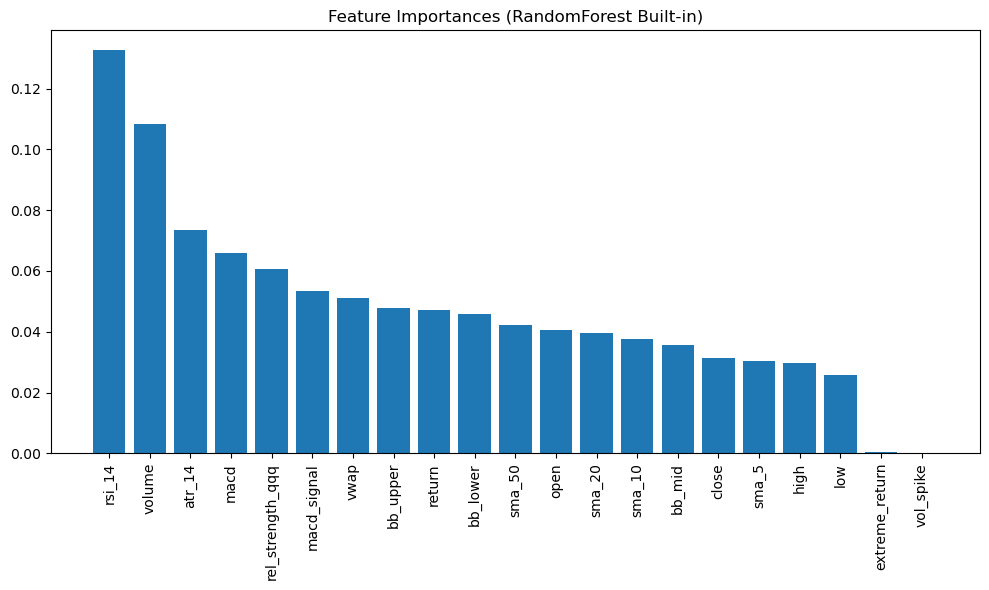

Top features by built-in importance:
rsi_14: 0.1326
volume: 0.1084
atr_14: 0.0735
macd: 0.0660
rel_strength_qqq: 0.0608
macd_signal: 0.0535
vwap: 0.0512
bb_upper: 0.0478
return: 0.0471
bb_lower: 0.0458
sma_50: 0.0423
open: 0.0407
sma_20: 0.0394
sma_10: 0.0376
bb_mid: 0.0355
close: 0.0315
sma_5: 0.0303
high: 0.0298
low: 0.0256
extreme_return: 0.0006
vol_spike: 0.0000


In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Built-in RandomForest importance
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = np.array(feature_cols)

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (RandomForest Built-in)")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

# Optional: print top features numerically
print("Top features by built-in importance:")
for idx in indices:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


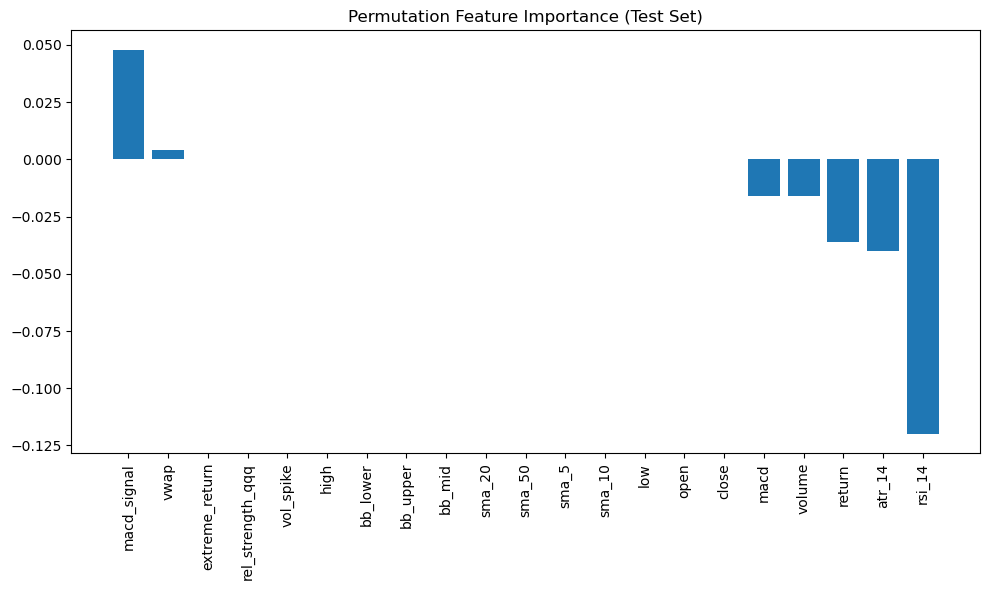


Permutation importances:
macd_signal: 0.0480
vwap: 0.0040
extreme_return: 0.0000
rel_strength_qqq: 0.0000
vol_spike: 0.0000
high: 0.0000
bb_lower: 0.0000
bb_upper: 0.0000
bb_mid: 0.0000
sma_20: 0.0000
sma_50: 0.0000
sma_5: 0.0000
sma_10: 0.0000
low: 0.0000
open: 0.0000
close: 0.0000
macd: -0.0160
volume: -0.0160
return: -0.0360
atr_14: -0.0400
rsi_14: -0.1200


In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
)
sorted_idx = result.importances_mean.argsort()[::-1]

plt.figure(figsize=(10, 6))
plt.title("Permutation Feature Importance (Test Set)")
plt.bar(range(X_test.shape[1]), result.importances_mean[sorted_idx], align="center")
plt.xticks(range(X_test.shape[1]), feature_names[sorted_idx], rotation=90)
plt.tight_layout()
plt.show()

print("\nPermutation importances:")
for idx in sorted_idx:
    print(f"{feature_names[idx]}: {result.importances_mean[idx]:.4f}")


### Simulated PnL: Model-guided trades

Assume we go long on every day where model predicts 'up', and exit at next day's close.


In [11]:
test_long = test[(test['trend_up'] == 1) & (test['in_play_120'] == 1)].copy()


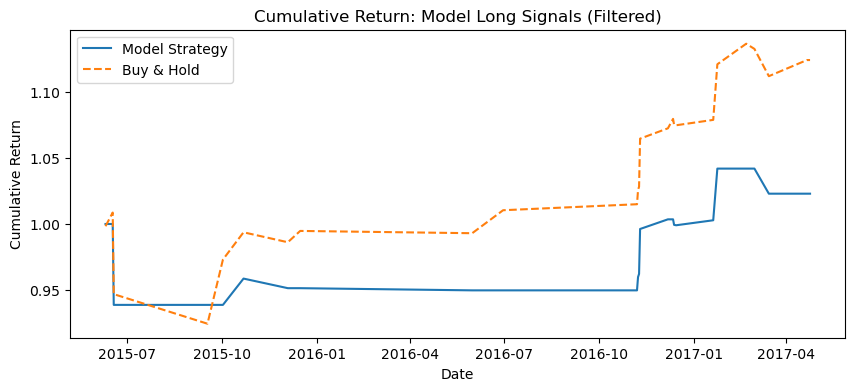

Total strategy return (no compounding): 0.0266
Number of model trades in test set: 14
Sharpe ratio: 0.97
Max drawdown: 6.13%
Win rate: 28.00%
Loss rate: 24.00%
Average trade return: 0.0020


In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate returns as before
test_long = test_long.copy()
test_long['model_signal'] = test_pred
test_long['strategy_return'] = test_long['model_signal'] * (test_long['close'].shift(-1) - test_long['close']) / test_long['close']

# Cumulative return (no leverage, no slippage/cost)
test_long['cumulative_return'] = (1 + test_long['strategy_return'].fillna(0)).cumprod()

# Benchmark: Buy and hold
test_long['buyhold_return'] = (test_long['close'].shift(-1) - test_long['close']) / test_long['close']
test_long['buyhold_cumret'] = (1 + test_long['buyhold_return'].fillna(0)).cumprod()

plt.figure(figsize=(10, 4))
plt.plot(test_long['date'], test_long['cumulative_return'], label='Model Strategy')
plt.plot(test_long['date'], test_long['buyhold_cumret'], label='Buy & Hold', linestyle='--')
plt.title('Cumulative Return: Model Long Signals (Filtered)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# Trade metrics
total_return = test_long['strategy_return'].sum()
num_trades = test_long['model_signal'].sum()
sharpe = (test_long['strategy_return'].mean() / test_long['strategy_return'].std()) * np.sqrt(252) if test_long['strategy_return'].std() > 0 else np.nan
max_drawdown = (test_long['cumulative_return'].cummax() - test_long['cumulative_return']).max()
win_rate = (test_long['strategy_return'] > 0).mean()
loss_rate = (test_long['strategy_return'] < 0).mean()
avg_trade_return = test_long['strategy_return'][test_long['model_signal'] != 0].mean()

print(f"Total strategy return (no compounding): {total_return:.4f}")
print(f"Number of model trades in test set: {int(num_trades)}")
print(f"Sharpe ratio: {sharpe:.2f}")
print(f"Max drawdown: {max_drawdown:.2%}")
print(f"Win rate: {win_rate:.2%}")
print(f"Loss rate: {loss_rate:.2%}")
print(f"Average trade return: {avg_trade_return:.4f}")


### Notes

- The model is strictly filtered to avoid periods that don’t meet our core assumptions.
- All metrics and returns are out-of-sample, using only validation and test splits.
- In practice, transaction costs and slippage should be subtracted for a realistic PnL estimate.



In [21]:
##The following code is used in lieu of a Quality Monitor due to static data in our model. If we were using streaming data, we create an endpoint and base the
##Quality Monitor on that. In using this quality method we see that our model is guessing at about a 50/50 split, keeping that our model is not performing well.
##This tracks with real-world performance.

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

pred_col = 'trend_up'
label_col = 'target_up'

monitor_df = df_feat[[pred_col, label_col]].dropna()

# Metrics
accuracy = accuracy_score(monitor_df[label_col], monitor_df[pred_col])
precision = precision_score(monitor_df[label_col], monitor_df[pred_col], average='weighted')
recall = recall_score(monitor_df[label_col], monitor_df[pred_col], average='weighted')
f1 = f1_score(monitor_df[label_col], monitor_df[pred_col], average='weighted')
conf_matrix = confusion_matrix(monitor_df[label_col], monitor_df[pred_col])

# Report
print("Model Monitoring Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:")
print(classification_report(monitor_df[label_col], monitor_df[pred_col]))

Model Monitoring Metrics:
Accuracy : 0.4946
Precision: 0.4966
Recall   : 0.4946
F1 Score : 0.4954

Confusion Matrix:
 [[1064 1203]
 [1316 1401]]

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.47      0.46      2267
           1       0.54      0.52      0.53      2717

    accuracy                           0.49      4984
   macro avg       0.49      0.49      0.49      4984
weighted avg       0.50      0.49      0.50      4984



In [ ]:
## The code below is an experiment to see if the model improves when we sync the input data with moon phase information. 
## There is no expecation of improvement, but rather exploratory in nature. 

In [22]:
pip install ephem

  Using cached ephem-4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.1 kB)
Using cached ephem-4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import numpy as np
import ephem

df_feat = pd.read_csv("data/spy_daily_features.csv")
df_feat['date'] = pd.to_datetime(df_feat['date'])

def calculate_moon_phase(date):
    obs_date = ephem.Date(date.strftime('%Y/%m/%d'))
    return ephem.Moon(obs_date).phase

df_feat['moon_phase'] = df_feat['date'].apply(calculate_moon_phase)
df_feat['moon_phase_sin'] = np.sin(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat['moon_phase_cos'] = np.cos(2 * np.pi * df_feat['moon_phase'] / 29.53)

df_feat.to_csv("data/spy_daily_features_with_moon.csv", index=False)


In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load feature dataset
df_feat = pd.read_csv("data/spy_daily_features.csv")
df_feat['date'] = pd.to_datetime(df_feat['date'])

# Add moon phase features
def calculate_moon_phase(date):
    if pd.isnull(date):
        return np.nan
    obs_date = ephem.Date(date.strftime('%Y/%m/%d'))
    return ephem.Moon(obs_date).phase

df_feat['moon_phase'] = df_feat['date'].apply(calculate_moon_phase)
df_feat['moon_phase_sin'] = np.sin(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat['moon_phase_cos'] = np.cos(2 * np.pi * df_feat['moon_phase'] / 29.53)

# Drop missing values
df_feat = df_feat.dropna()

# Define target: predict if next day's return is positive
df_feat['target'] = (df_feat['return'].shift(-1) > 0).astype(int)
df_feat = df_feat.dropna()

# One-hot encode 'regime'
df_feat = pd.get_dummies(df_feat, columns=['regime'])

# Define features
features_base = [col for col in df_feat.columns if col not in ['date', 'target', 'moon_phase', 'moon_phase_sin', 'moon_phase_cos']]
features_with_moon = features_base + ['moon_phase', 'moon_phase_sin', 'moon_phase_cos']

# Split datasets
X_base = df_feat[features_base]
X_moon = df_feat[features_with_moon]
y = df_feat['target']

Xb_train, Xb_test, yb_train, yb_test = train_test_split(X_base, y, test_size=0.2, shuffle=False)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(X_moon, y, test_size=0.2, shuffle=False)

# Train models
clf_base = RandomForestClassifier(n_estimators=100, random_state=42)
clf_base.fit(Xb_train, yb_train)

clf_moon = RandomForestClassifier(n_estimators=100, random_state=42)
clf_moon.fit(Xm_train, ym_train)

# Evaluate models
print("Base Model:\n")
print(classification_report(yb_test, clf_base.predict(Xb_test)))

print("\nModel With Moon Phase Features:\n")
print(classification_report(ym_test, clf_moon.predict(Xm_test)))

Base Model:

              precision    recall  f1-score   support

           0       0.45      0.75      0.56       465
           1       0.48      0.20      0.28       532

    accuracy                           0.46       997
   macro avg       0.46      0.48      0.42       997
weighted avg       0.46      0.46      0.41       997


Model With Moon Phase Features:

              precision    recall  f1-score   support

           0       0.46      0.72      0.56       465
           1       0.51      0.25      0.33       532

    accuracy                           0.47       997
   macro avg       0.48      0.49      0.45       997
weighted avg       0.48      0.47      0.44       997



In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load data
df_feat = pd.read_csv("data/spy_daily_features.csv")
df_feat['date'] = pd.to_datetime(df_feat['date'])

# Add moon phase
def calculate_moon_phase(date):
    if pd.isnull(date):
        return np.nan
    obs_date = ephem.Date(date.strftime('%Y/%m/%d'))
    return ephem.Moon(obs_date).phase

df_feat['moon_phase'] = df_feat['date'].apply(calculate_moon_phase)
df_feat['moon_phase_sin'] = np.sin(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat['moon_phase_cos'] = np.cos(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat = df_feat.dropna()

# Create target: next-day positive return
df_feat['target'] = (df_feat['return'].shift(-1) > 0).astype(int)
df_feat = df_feat.dropna()

# One-hot encode 'regime'
df_feat = pd.get_dummies(df_feat, columns=['regime'])

# Features
features_with_moon = [col for col in df_feat.columns if col not in ['date', 'target']]
X = df_feat[features_with_moon]
y = df_feat['target']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train XGBoost
model = XGBClassifier(n_estimators=200, max_depth=4, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:57:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.48      0.30      0.37       465
           1       0.54      0.71      0.61       532

    accuracy                           0.52       997
   macro avg       0.51      0.51      0.49       997
weighted avg       0.51      0.52      0.50       997



<Figure size 1000x600 with 0 Axes>

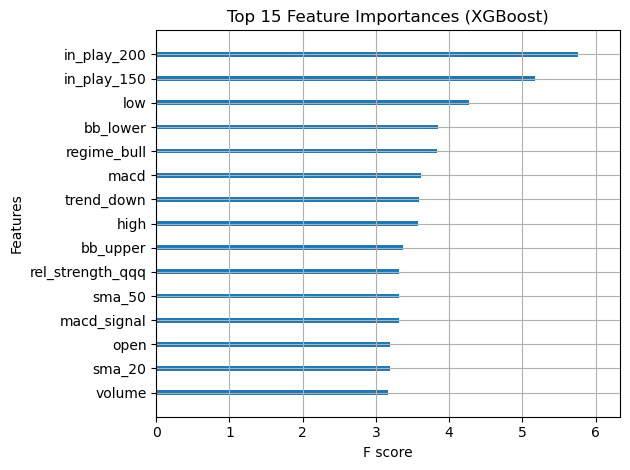

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plot_importance(model, max_num_features=15, importance_type='gain', show_values=False)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


In [32]:
# Load and prepare data
df_feat = pd.read_csv("data/spy_daily_features.csv")
df_feat['date'] = pd.to_datetime(df_feat['date'])

def calculate_moon_phase(date):
    if pd.isnull(date):
        return np.nan
    obs_date = ephem.Date(date.strftime('%Y/%m/%d'))
    return ephem.Moon(obs_date).phase

df_feat['moon_phase'] = df_feat['date'].apply(calculate_moon_phase)
df_feat['moon_phase_sin'] = np.sin(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat['moon_phase_cos'] = np.cos(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat = df_feat.dropna()

df_feat['target'] = (df_feat['return'].shift(-1) > 0).astype(int)
df_feat = df_feat.dropna()
df_feat = pd.get_dummies(df_feat, columns=['regime'])

# Define features
features_with_moon = [col for col in df_feat.columns if col not in ['date', 'target']]
X = df_feat[features_with_moon]
y = df_feat['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Hyperparameter tuning
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=10,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

# Evaluate best model
best_xgb = random_search.best_estimator_
y_pred = best_xgb.predict(X_test)
print("Best Hyperparameters:", random_search.best_params_)
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:00:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:00:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:00:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:00:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.01, 'colsample_bytree': 0.8}
              precision    recall  f1-score   support

           0       0.45      0.03      0.06       465
           1       0.53      0.97      0.69       532

    accuracy                           0.53       997
   macro avg       0.49      0.50      0.37       997
weighted avg       0.50      0.53      0.39       997



In [33]:
# Load data
df_feat = pd.read_csv("data/spy_daily_features.csv")
df_feat['date'] = pd.to_datetime(df_feat['date'])

# Add moon phase features
def calculate_moon_phase(date):
    if pd.isnull(date):
        return np.nan
    obs_date = ephem.Date(date.strftime('%Y/%m/%d'))
    return ephem.Moon(obs_date).phase

df_feat['moon_phase'] = df_feat['date'].apply(calculate_moon_phase)
df_feat['moon_phase_sin'] = np.sin(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat['moon_phase_cos'] = np.cos(2 * np.pi * df_feat['moon_phase'] / 29.53)
df_feat = df_feat.dropna()

# Reframe target: predict if return > 0.2%
df_feat['target'] = (df_feat['return'].shift(-1) > 0.002).astype(int)
df_feat = df_feat.dropna()
df_feat = pd.get_dummies(df_feat, columns=['regime'])

# Define features
features_with_moon = [col for col in df_feat.columns if col not in ['date', 'target']]
X = df_feat[features_with_moon]
y = df_feat['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Add scale_pos_weight
class_weights = y_train.value_counts()
scale_pos_weight = class_weights[0] / class_weights[1]

# Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Apply probability threshold
y_probs = model.predict_proba(X_test)[:, 1]
y_pred_thresh = (y_probs > 0.6).astype(int)

# Evaluate
print(classification_report(y_test, y_pred_thresh))


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:00:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.58      0.96      0.72       575
           1       0.48      0.05      0.10       422

    accuracy                           0.57       997
   macro avg       0.53      0.51      0.41       997
weighted avg       0.54      0.57      0.46       997



/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.p

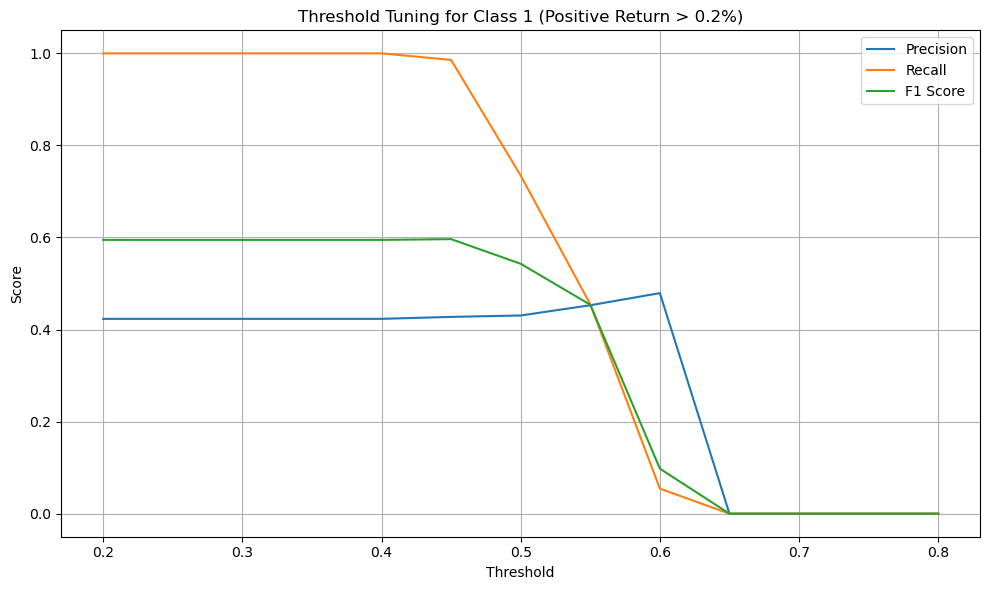

Best threshold: 0.45 — F1 Score: 0.60


In [34]:
# Sweep threshold values from 0.2 to 0.8
thresholds = np.arange(0.2, 0.81, 0.05)
precision_list, recall_list, f1_list = [], [], []

# Evaluate precision, recall, and F1 at each threshold
for threshold in thresholds:
    y_pred_thresh = (y_probs > threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thresh, average='binary', pos_label=1
    )
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for Class 1 (Positive Return > 0.2%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Report best threshold
best_idx = np.argmax(f1_list)
best_threshold = thresholds[best_idx]
best_f1 = f1_list[best_idx]
print(f"Best threshold: {best_threshold:.2f} — F1 Score: {best_f1:.2f}")


/opt/conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [16:58:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1744329020674/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: 

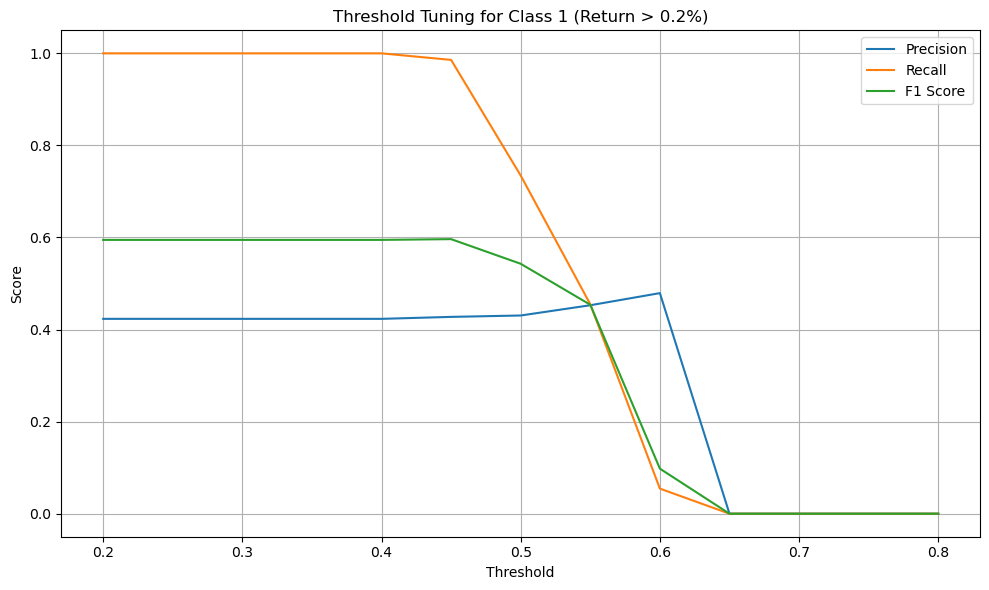

Best threshold: 0.45 — F1 Score: 0.60

Final Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.03      0.06       575
           1       0.43      0.99      0.60       422

    accuracy                           0.44       997
   macro avg       0.59      0.51      0.33       997
weighted avg       0.61      0.44      0.29       997



In [31]:
# XGBoost Model with Moon Phase Feature and Threshold Tuning

import pandas as pd
import numpy as np
import ephem
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support

# Load and preprocess data
df = pd.read_csv("data/spy_daily_features.csv")
df['date'] = pd.to_datetime(df['date'])

# Calculate moon phase
def calculate_moon_phase(date):
    if pd.isnull(date):
        return np.nan
    obs_date = ephem.Date(date.strftime('%Y/%m/%d'))
    return ephem.Moon(obs_date).phase

df['moon_phase'] = df['date'].apply(calculate_moon_phase)
df['moon_phase_sin'] = np.sin(2 * np.pi * df['moon_phase'] / 29.53)
df['moon_phase_cos'] = np.cos(2 * np.pi * df['moon_phase'] / 29.53)

# Drop missing values
df = df.dropna()

# Define target: next-day return > 0.2%
df['target'] = (df['return'].shift(-1) > 0.002).astype(int)
df = df.dropna()

# One-hot encode regime
df = pd.get_dummies(df, columns=['regime'])

# Feature selection
features = [col for col in df.columns if col not in ['date', 'target']]
X = df[features]
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Handle class imbalance
class_weights = y_train.value_counts()
scale_pos_weight = class_weights[0] / class_weights[1]

# Train XGBoost model
model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Predict probabilities
y_probs = model.predict_proba(X_test)[:, 1]

# Threshold tuning
thresholds = np.arange(0.2, 0.81, 0.05)
precision_list, recall_list, f1_list = [], [], []

for threshold in thresholds:
    y_pred_thresh = (y_probs > threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thresh, average='binary', pos_label=1
    )
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

# Plot tuning results
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_list, label='Precision')
plt.plot(thresholds, recall_list, label='Recall')
plt.plot(thresholds, f1_list, label='F1 Score')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold Tuning for Class 1 (Return > 0.2%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Best threshold
best_idx = np.argmax(f1_list)
best_threshold = thresholds[best_idx]
print(f"Best threshold: {best_threshold:.2f} — F1 Score: {f1_list[best_idx]:.2f}")

# Final predictions with best threshold
y_final_pred = (y_probs > best_threshold).astype(int)
print("\nFinal Classification Report:")
print(classification_report(y_test, y_final_pred))

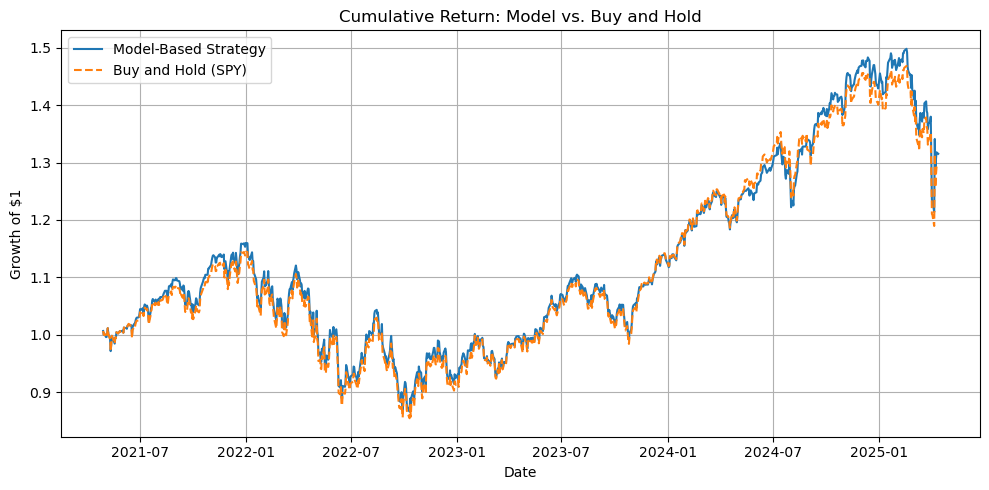

In [35]:
# Get true next-day returns
df_eval = df.iloc[-len(y_test):].copy()
df_eval['y_prob'] = y_probs
df_eval['model_signal'] = (df_eval['y_prob'] > 0.45).astype(int)

# Calculate real next-day returns
df_eval['next_return'] = df_eval['return'].shift(-1)

# Strategy returns: only take next day's return if model predicts 1
df_eval['strategy_return'] = df_eval['next_return'] * df_eval['model_signal']

# Buy-and-hold baseline: same period
df_eval['baseline_return'] = df_eval['next_return']

# Cumulative returns
df_eval['cum_strategy'] = (1 + df_eval['strategy_return']).cumprod()
df_eval['cum_baseline'] = (1 + df_eval['baseline_return']).cumprod()

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(df_eval['date'], df_eval['cum_strategy'], label='Model-Based Strategy')
plt.plot(df_eval['date'], df_eval['cum_baseline'], label='Buy and Hold (SPY)', linestyle='--')
plt.title('Cumulative Return: Model vs. Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [39]:
strategy_returns = df_eval['strategy_return'].dropna()
baseline_returns = df_eval['baseline_return'].dropna()

print("Model-Based Total Return:", df_eval['cum_strategy'].iloc[-1] - 1)
print("Buy-and-Hold Total Return:", df_eval['cum_baseline'].iloc[-1] - 1)
print("Number of Trades Taken:", df_eval['model_signal'].sum())
print("Average Return per Trade:", strategy_returns[df_eval['model_signal'] == 1].mean())
print("Strategy Sharpe Ratio (daily):", strategy_returns.mean() / strategy_returns.std())


Model-Based Total Return: -0.15877934091209467
Buy-and-Hold Total Return: 0.2890752218495416
Number of Trades Taken: 972
Average Return per Trade: -0.00022887993366722912
Strategy Sharpe Ratio (daily): -0.024341449848482414
